---
CSC 268 Lab 10:  Fourier Transform
---

This lab begins our exploration of the frequency domain, an alternate representation for images.  We will focus here more on the implementation and less on the theory behind the methods.

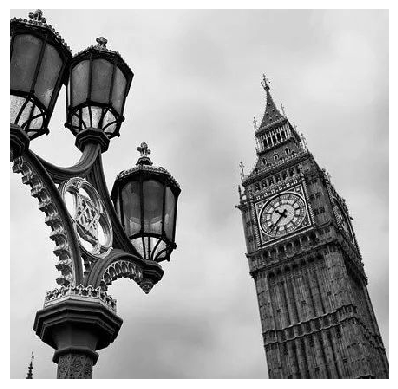

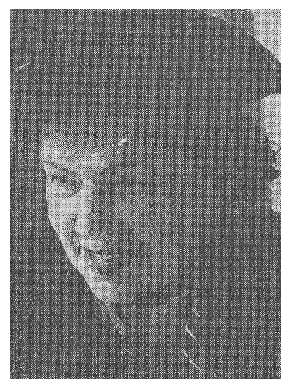

In [1]:
import cv2 as cv
import numpy as np
from scipy.fft import fft, ifft, fft2, ifft2, fftn, ifftn
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('image', cmap='gray')

def imshow(img,cmap=None):
    plt.imshow(img,cmap=cmap,interpolation='none')
    plt.axis('off')
    plt.show()
    
bigben = cv.imread('bigben.jpg',0).astype(np.float32)/255.0
irena = cv.imread('irena.jpg',0).astype(np.float32)/255.0
imshow(bigben)
imshow(irena)

We'll begin with some basics.  The fast Fourier transform and its inverse are both O(n log n) operations.  For images, we will use the 2D implementations `fft2` and `ifft2`.  We'll also use `fftshift` and `ifftshift` to bring the low frequency components to the middle of the Fourier space, for better visualization.

Note that the Fourier transform is defined using complex numbers.  Although we start with a real-valued image, the result of the transform will have complex components.  When visualizing images in Fourier space, it is customary to display the log of the magnitude of the Fourier components.  Although the phase angles of the terms are important for recovering a specific image, they can usually be left as is.

(427, 437) (427, 437)


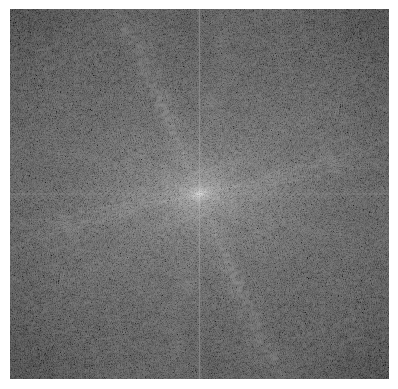

0.007301473058760166


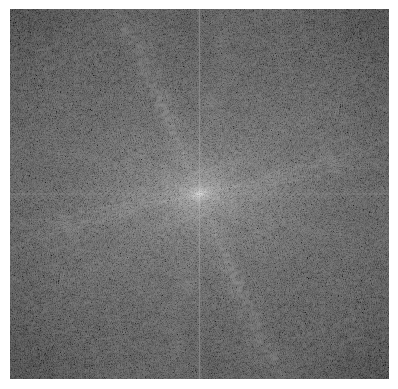

In [2]:
fbb = fft2(bigben)  # here we use the scikit fft implementation
print(bigben.shape,fbb.shape)
fbbs = np.fft.fftshift(fbb)
ms = np.log(np.abs(fbbs))
imshow(ms)
fbb2 = np.fft.fft2(bigben)  # here we use the numpy fft implementation.  They are more or less identical
print(np.abs((fbb-fbb2)).max())
fbb2s = np.fft.fftshift(fbb)
ms2 = np.log(np.abs(fbb2s))
imshow(ms2)

One simple thing one can easily do in Fourier space is to separate the high and low frequency portions of the image.  People will sometimes talk about "bandpass" filters -- highbass, lowpass, etc.  (The terms come originally from audio processing, where Fourier decompositions are also used.)  Essentially, these are filters which block some combination of the high, middle, or low frequency components while leaving others intact.  We can do something equivalent for images, separating the high from the low.

In the block below, zero out a 40x40 block of frequencies at the center of the Fourier image.  This is a highpass filter (since we have blocked the low frequencies).  If we subtract the highpass result from the original image, we will have only the low frequencies left.  This is a lowpass filter.  When we convert each one back to image space, we see that one captures all the principal structure of the image, while the other captures the local detail.  Adding the two results together will recover the original image.  (Note:  there are some ripple artifacts visible in the results because we used a rather crude square filter on the frequencies.  Applying a circular filter with a gradual cutoff would improve the result.)

If you have time, see what happens if you zero a larger block of frequencies.  How does this affect the result?

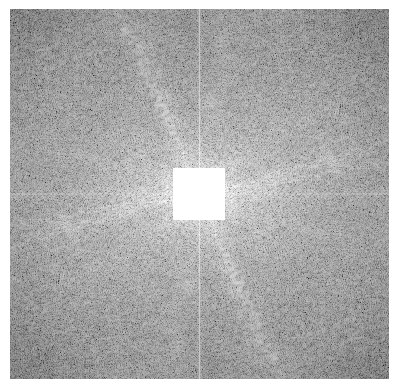

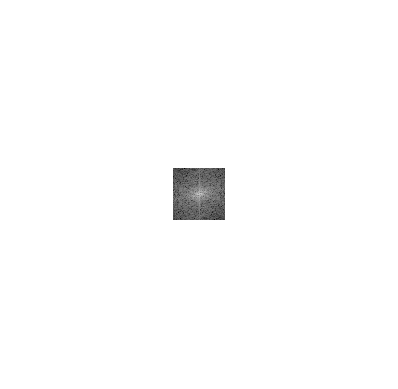

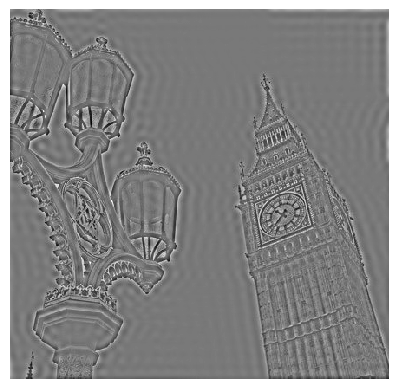

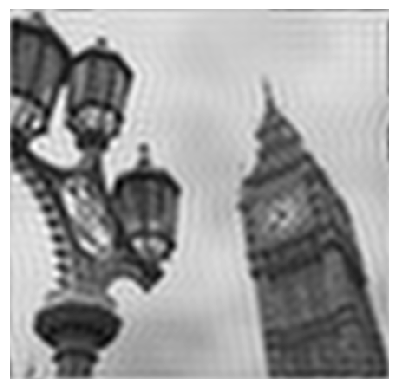

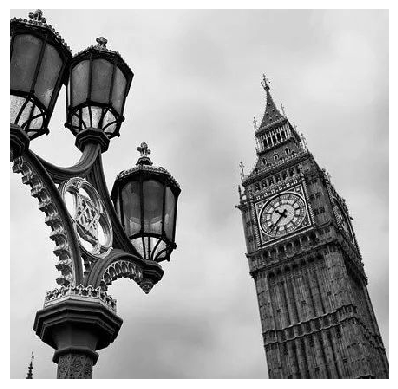

In [3]:
fbbshi = fbbs.copy()
#fbbshi[193:233,198:238] = 0
fbbshi[183:243,188:248] = 0
fbbslo = fbbs-fbbshi
imshow(np.ma.log(np.abs(fbbshi)))
imshow(np.ma.log(np.abs(fbbslo)))
imshow(ifft2(np.fft.ifftshift(fbbshi)).real)
imshow(ifft2(np.fft.ifftshift(fbbslo)).real)
#imshow(ifft2(np.fft.ifftshift(fbbs)).real)
imshow(ifft2(np.fft.ifftshift(fbbshi)).real+ifft2(np.fft.ifftshift(fbbslo)).real)

We can achieve other things in frequency space that would be difficult to do in regular image space.  The second image loaded above is an old newspaper clipping of Polish actress Irena Grywińska (courtesy Wikipedia).  The halftone image has not scanned well.  However, because the added noise is periodic in nature it is a good candidate for processing in Fourier space.  

We begin by taking a look at the frequency spectrum.  Unlike the example above, which has most of its energy near the origin, in this image we see starlike clusters of abnormal weight at a number of high frequency locations far from the origin.  Perhaps these correspond to the periodic noise in the image.  We will try zeroing out some of these areas.

(599, 439) (599, 439)


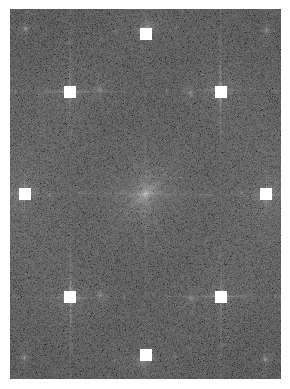

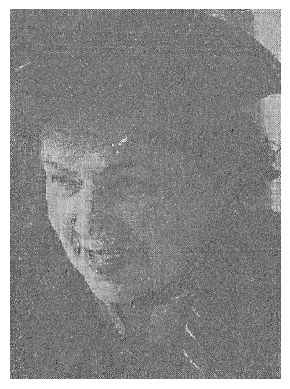

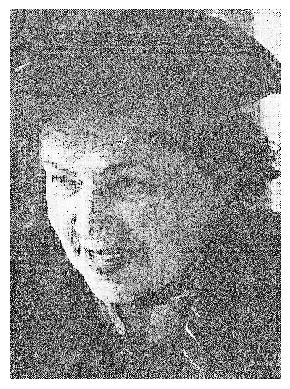

In [4]:
fir = fft2(irena)
print(irena.shape,fir.shape)
firs = np.fft.fftshift(fir)
#imshow(np.log(np.abs(firs)))

firs2 = firs.copy()
firs2[124:144,87:107] = 0
firs2[456:476,87:107] = 0
firs2[456:476,332:352] = 0
firs2[124:144,332:352] = 0

#imshow(np.ma.log(np.abs(firs2)))
#imshow(ifft2(np.fft.ifftshift(firs2)).real)

firs2[290:310,14:34] = 0
firs2[30:50,210:230] = 0
firs2[550:570,210:230] = 0
firs2[290:310,405:425] = 0
imshow(np.ma.log(np.abs(firs2)))
imshow(ifft2(np.fft.ifftshift(firs2)).real)
imshow(cv.equalizeHist((255*ifft2(np.fft.ifftshift(firs2)).real).astype(np.uint8)))

The result looks somewhat better, but we have still not removed all the noise.  Add code that targets the four other concentrations of high-frequency noise and see what happens.  If you have time, there are other less prominent high-frequency peaks that you can remove.  You may also wish to apply histogram equalization to the overall result, since the image suffers from a lack of contrast in addition to the noise problem.

(599, 439) 7.460592517853822e-17 6.366269874840506e-05


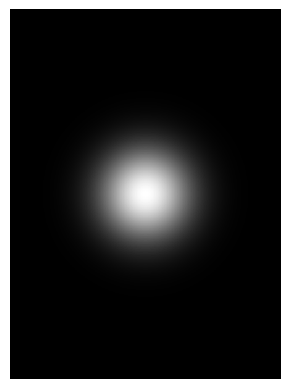

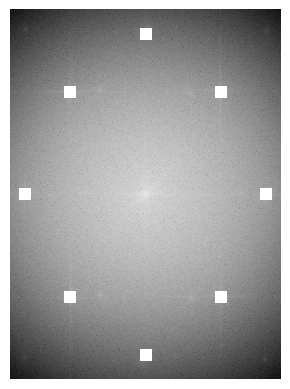

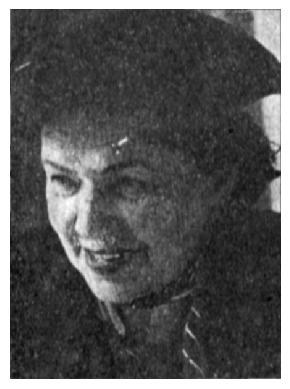

In [14]:
#from scipy.ndimage import gaussian_filter
sigma = 50
gf = np.matmul(cv.getGaussianKernel(irena.shape[0],sigma),cv.getGaussianKernel(irena.shape[1],sigma).T)
print(gf.shape,gf.min(),gf.max())
gf = gf/gf.max()
imshow(gf)

firs3 = firs2*gf
#firs3 = firs2.copy()
#firs3[144:456,107:332] = 0
#firs3 = firs2-firs3
imshow(np.ma.log(np.abs(firs3)))
imshow(ifft2(np.fft.ifftshift(firs3)).real)

The final thing you should do if you have time is to experiment with simple combinations of Fourier components.  We'll work with a 128x128 image.  Begin with a matrix of all zeros, and set just a single component to 1.  Then compute the inverse Fourier transform and display the resulting image.  You should see the visualization of a wave function, with the periood and direction determined by the specific point you chose to set.  Try a couple of different points, with both low and high frequencies.  (The low frequencies are located around 64,64 in the centered Fourier image.)  You can also adjust the phase of the waves by adding an imaginary component to the value.

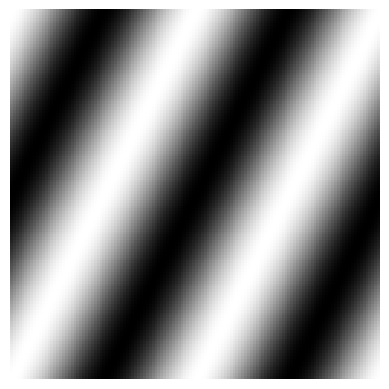

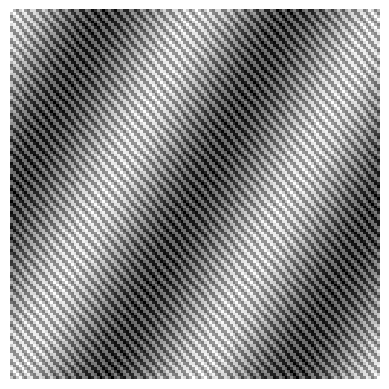

In [30]:
f = np.zeros((128,128),dtype=complex)
f[65,66] = 1 # try: 1+1j
imshow(ifft2(np.fft.ifftshift(f)).real)
f[94,30] = 1 # try: 1+1j
imshow(ifft2(np.fft.ifftshift(f)).real)